# Collect results from multiple runs of `jaxmodel.ipynb` 

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [2]:
# papermill params
results_dir = 'papermill_results/'

In [3]:
# recurse through the subdirectories, parsing the directory name, and adding it to the dataframe
keys = []
mut_df_collection = pd.DataFrame()
for dir in glob.glob(f'{results_dir}*/'):
    mut_df = pd.read_csv(f"{dir}/mutations_df.csv")
    for annotation in dir.split("/")[-2].split("--"):
        key, val = annotation.split("=")
        keys.append(key)
        mut_df[key] = val
    mut_df_collection = pd.concat([mut_df_collection, mut_df])
mut_df_collection

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,beta_Delta,shift_Delta,beta_Omicron_BA1,shift_Omicron_BA1,beta_Omicron_BA2,shift_Omicron_BA2,fusionreg,global_epistasis,l2reg,replicate
0,M1F,M,1,F,3,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.0,Sigmoid,0.0001,2
1,M1I,M,1,I,10,3,8,-2.375888,0.000000,-2.375888,0.0,-2.375888,0.000000,2.0,Sigmoid,0.0001,2
2,M1K,M,1,K,5,0,0,-0.927250,-0.927250,0.000000,0.0,0.000000,0.000000,2.0,Sigmoid,0.0001,2
3,M1L,M,1,L,7,0,1,-0.977213,-0.977213,0.000000,0.0,0.000000,0.000000,2.0,Sigmoid,0.0001,2
4,M1N,M,1,N,1,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.0,Sigmoid,0.0001,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788,S1252T,S,1252,T,17,91,85,-0.226076,0.000000,-0.226076,0.0,-0.226076,0.000000,3.0,Sigmoid,0.0001,1
9789,S1252V,S,1252,V,15,64,56,0.191265,0.000000,0.191265,0.0,0.125828,-0.065436,3.0,Sigmoid,0.0001,1
9790,S1252W,S,1252,W,2,17,25,0.140727,0.000000,0.140727,0.0,0.140727,0.000000,3.0,Sigmoid,0.0001,1
9791,S1252Y,S,1252,Y,30,76,107,0.357167,0.000000,0.357167,0.0,0.357167,0.000000,3.0,Sigmoid,0.0001,1


Filter to mutations that are present in all replicates and all conditions.

In [4]:
# we count the number of rows with this mutation and require that that number is maximal (all replicates and parameter sets), and that the times_seen is all non-zero
muts_to_keep = (mut_df_collection.mutation.value_counts() == mut_df_collection.mutation.value_counts().max())
muts_to_keep = muts_to_keep.loc[muts_to_keep].index

mut_df_collection.query("mutation in @muts_to_keep", inplace=True)

mut_df_collection.query("times_seen_Delta > 0 & times_seen_Omicron_BA1 > 0 & times_seen_Omicron_BA2 > 0", inplace=True)

mut_df_collection

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,beta_Delta,shift_Delta,beta_Omicron_BA1,shift_Omicron_BA1,beta_Omicron_BA2,shift_Omicron_BA2,fusionreg,global_epistasis,l2reg,replicate
1,M1I,M,1,I,10,3,8,-2.375888,0.0,-2.375888,0.0,-2.375888,0.000000,2.0,Sigmoid,0.0001,2
10,F2L,F,2,L,10,5,13,-0.007462,0.0,-0.007462,0.0,0.054860,0.062323,2.0,Sigmoid,0.0001,2
12,F2S,F,2,S,1,9,9,-0.038369,0.0,-0.038369,0.0,-0.038369,0.000000,2.0,Sigmoid,0.0001,2
13,F2V,F,2,V,1,3,2,-0.073942,0.0,-0.073942,0.0,-0.073942,0.000000,2.0,Sigmoid,0.0001,2
14,F2Y,F,2,Y,1,1,2,-0.289086,0.0,-0.289086,0.0,-0.289086,0.000000,2.0,Sigmoid,0.0001,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9787,S1252R,S,1252,R,9,53,59,0.127759,0.0,0.127759,0.0,0.127759,0.000000,3.0,Sigmoid,0.0001,1
9788,S1252T,S,1252,T,17,91,85,-0.226076,0.0,-0.226076,0.0,-0.226076,0.000000,3.0,Sigmoid,0.0001,1
9789,S1252V,S,1252,V,15,64,56,0.191265,0.0,0.191265,0.0,0.125828,-0.065436,3.0,Sigmoid,0.0001,1
9790,S1252W,S,1252,W,2,17,25,0.140727,0.0,0.140727,0.0,0.140727,0.000000,3.0,Sigmoid,0.0001,1


In [5]:
mut_df_collection.query("muts == '-'").shape[0]

0

In [6]:
mut_df_collection['fusionreg'] = mut_df_collection['fusionreg'].astype(float)
mut_df_collection['l2reg'] = mut_df_collection['l2reg'].astype(float)

In [7]:
# make the mutation collection of parameter values tall for easier plotting
id_vars = ["mutation", "wts", "sites", "muts"] + list(set(keys)) #+ [c for c in mut_df_collection.columns if "times_seen" in c]
parameters = [c for c in mut_df_collection.columns if ("beta" in c) or ("shift" in c)]
tall_mut_df_collection = (
    mut_df_collection
    .melt(
        id_vars=id_vars,
        value_vars=parameters,
        var_name="parameter",
        value_name="value",
    )
    .pivot_table(
        index=list(set(id_vars + ["parameter"])-set(["replicate"])),
        columns="replicate",
        values="value"
    )
    .reset_index()
    .sort_values(by=["fusionreg", "l2reg"], ascending=False)
    .assign(
        is_stop=lambda x: x["mutation"].apply(lambda y: "*" in y)
    )
)
tall_mut_df_collection.index.name="index"
tall_mut_df_collection.head()

replicate,l2reg,wts,sites,mutation,muts,parameter,global_epistasis,fusionreg,1,2,is_stop
index,,,,,,,,,,,
3,0.0001,A,27,A27D,D,beta_Delta,Sigmoid,3.0,0.092353,-0.279221,False
7,0.0001,A,27,A27D,D,beta_Omicron_BA1,Sigmoid,3.0,0.092353,-0.279221,False
11,0.0001,A,27,A27D,D,beta_Omicron_BA2,Sigmoid,3.0,0.325656,0.173667,False
15,0.0001,A,27,A27D,D,shift_Delta,Sigmoid,3.0,0.000000,0.000000,False
19,0.0001,A,27,A27D,D,shift_Omicron_BA1,Sigmoid,3.0,0.000000,0.000000,False


Filter

In [8]:
# tall_mut_df_collection = tall_mut_df_collection.loc[(tall_mut_df_collection["1"] > -3) & (tall_mut_df_collection["2"] > -3)]
tall_mut_df_collection[["1", "2"]] = tall_mut_df_collection[["1", "2"]].clip(lower=-3)

In [9]:
tall_mut_df_collection.columns

Index(['l2reg', 'wts', 'sites', 'mutation', 'muts', 'parameter',
       'global_epistasis', 'fusionreg', '1', '2', 'is_stop'],
      dtype='object', name='replicate')

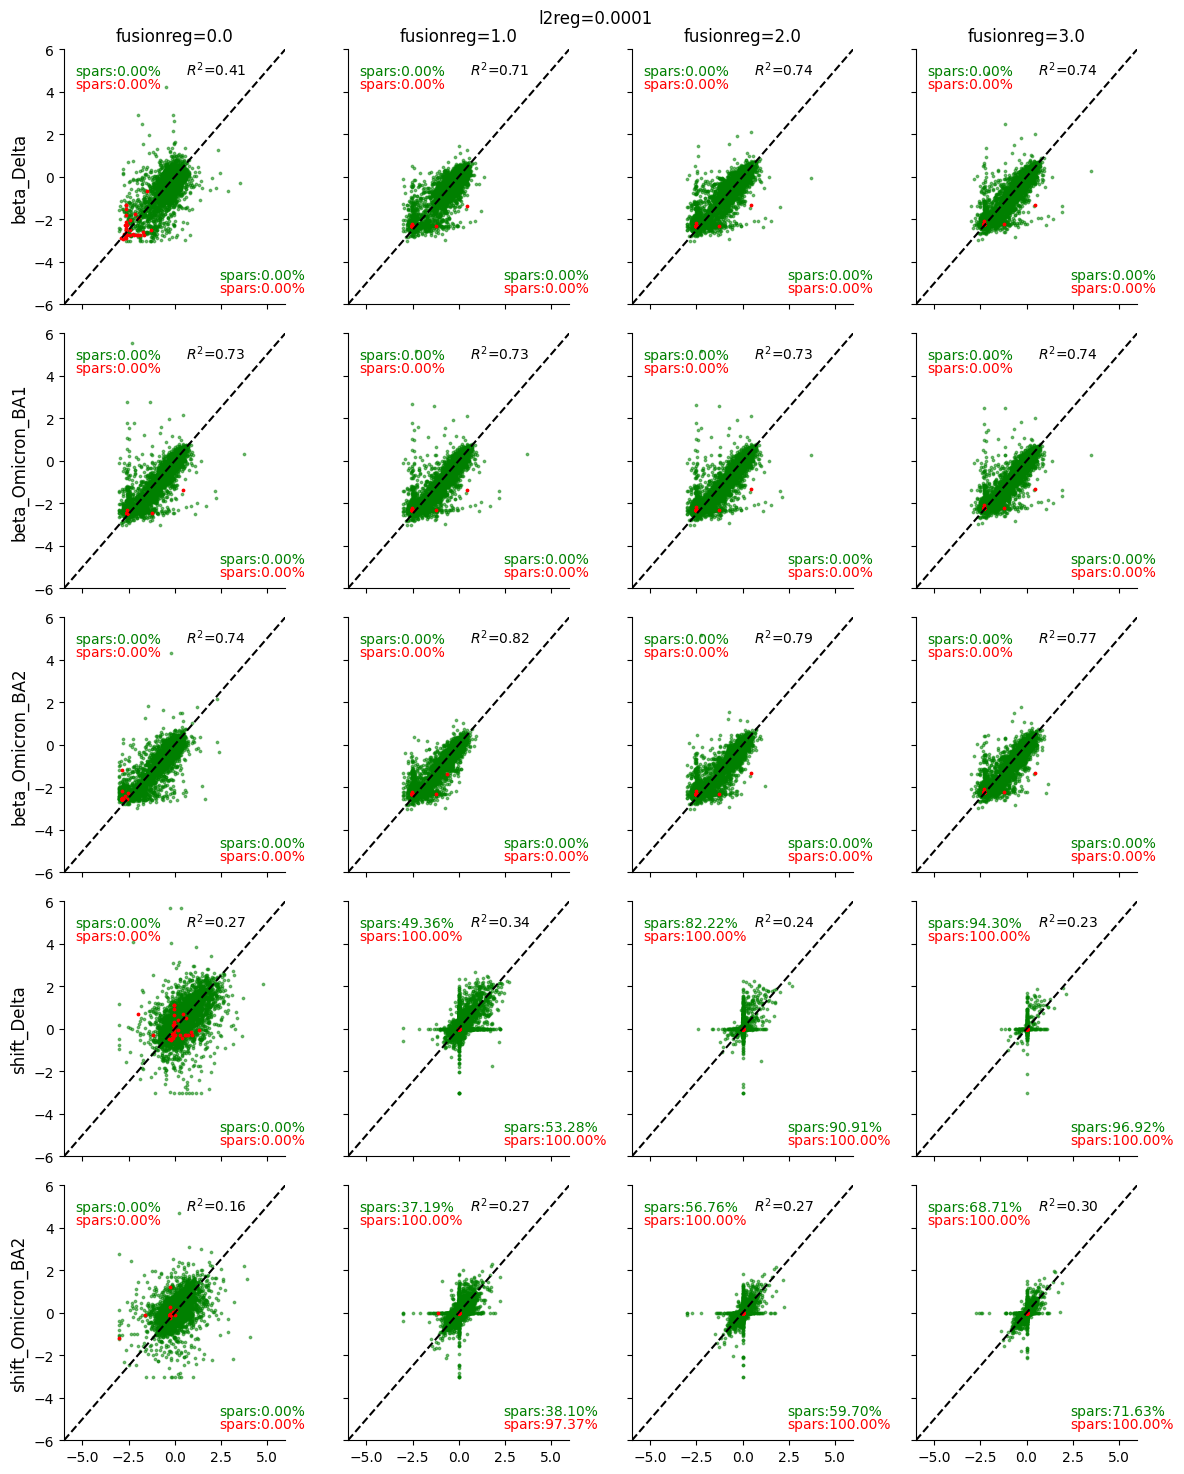

In [10]:
# use facets to create a scatter with column '1' on the x and column '2' on the y, facetted by parameter, fusionreg, and l2reg
for l2reg, df in tall_mut_df_collection.query(f"parameter != 'shift_Omicron_BA1'").dropna().groupby("l2reg"):

    # loop through each
    num_rows = len(df["parameter"].unique())
    num_cols = len(df["fusionreg"].unique())
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3), sharex=True, sharey=True, squeeze=False)

    for row, (parameter, sub_df) in enumerate(df.groupby("parameter")):
        for col, (fusionreg, sub_sub_df) in enumerate(sub_df.groupby("fusionreg")):
        
            iter_ax = ax[row, col]
            iter_ax.plot([0, 1], [0, 1], transform=iter_ax.transAxes, color="black", linestyle="--")

            iter_ax.scatter(
                sub_sub_df.query("~is_stop")["1"], sub_sub_df.query("~is_stop")["2"],
                color="green",
                alpha=0.5,
                s=3,
            )
            iter_ax.scatter(
                sub_sub_df.query("is_stop")["1"], sub_sub_df.query("is_stop")["2"],
                color="red",
                s=3,
            )
            # compute R squared and annotate figure
            r_squared = scipy.stats.pearsonr(sub_sub_df["1"], sub_sub_df["2"]).statistic ** 2
            iter_ax.annotate(f"$R^2$={r_squared:.2f}", xy=(0.55, 0.90), xycoords='axes fraction')

            # compute percentage of muts that are equal to zero for both stop, and non-stop mutations
            non_stop_zero = (sub_sub_df.query("~is_stop")["1"] == 0).mean()
            iter_ax.annotate(f"spars:{non_stop_zero:.2%}", xy=(.7, .10), xycoords='axes fraction', color="green")

            stop_zero = (sub_sub_df.query("is_stop")["1"] == 0).mean()
            iter_ax.annotate(f"spars:{stop_zero:.2%}", xy=(.7, .05), xycoords='axes fraction', color="red")

            non_stop_zero = (sub_sub_df.query("~is_stop")["2"] == 0).mean()
            iter_ax.annotate(f"spars:{non_stop_zero:.2%}", xy=(.05, .9), xycoords='axes fraction', color="green")

            stop_zero = (sub_sub_df.query("is_stop")["2"] == 0).mean()
            iter_ax.annotate(f"spars:{stop_zero:.2%}", xy=(.05, .85), xycoords='axes fraction', color="red")

            iter_ax.set_xlabel(None)
            iter_ax.set_ylabel(None)
            iter_ax.set_xlim(-6, 6)
            iter_ax.set_ylim(-6, 6)

            if row == 0:
                iter_ax.set_title(f"fusionreg={fusionreg}")
            if col == 0:
                iter_ax.set_ylabel(parameter, size=12)
    
    fig.suptitle(f"l2reg={l2reg}")
    sns.despine()
    plt.tight_layout()
    plt.show()
    # break
